Name: Patrick Ng  
Class: W261-2  
Date: Mar 10, 2016  
HW07

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## HW 7.0: Shortest path graph distances (toy networks)

```
In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!
```

#### Init function: convert an input file into an SSSP file
SSSP File format:  
```
JSON representaton of:
node id \t [ {adj-list dict}, [path from src], cost from src, status ]

e.g.
3       [{"2": 1, "4": 1}, [], 9223372036854775807, "U"]
```

In [20]:
%%writefile MrInitSssp.py
from numpy import argmin, array, random
import re
import numpy as np
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

class MrInitSssp(MRJob):

    SORT_VALUES = True  # Need 2nd sort
   
    def initValues(self, node):
        status = 'U'
        sps = [] # Unknown
        costFromSrc = sys.maxint # Unknown
            
        return (sps, costFromSrc, status)

    def mapper(self, _, line):
        # input format:
        # Json object:
        # 1       {'2': 1, '6': 1}
        
        fields = line.strip().split('\t')
        node = int(fields[0])

        # JSON uses double quote for string
        adjList = json.loads(fields[1].replace("'", '"'))
        
        sps, costFromSrc, status = self.initValues(node)
        
        # Output for the node, which is an outbound node
        yield node, [0, adjList, sps, costFromSrc, status]
        
        # Also need to output an empty entry for every nodes in the adjList.
        # It is needed for directed graph, so that in the reducer we can generate 
        # an entry for nodes which don't have an outbound link.
        for key in adjList.keys():
            yield int(key), [1]
            
    def reducer(self, node, values):
        value = values.next()
        
        # An outbound node will be seen first because we use 2nd sorting
        if value[0] == 0:
            # It's an outbound record
            yield node, value[1:]
        else:
            # For directed graph, generate an entry for a node which doesn't have an outbound 
            # link.
            sps, costFromSrc, status = self.initValues(node)
            yield node, [{}, sps, costFromSrc, status]
            
                                                  
if __name__ == '__main__':
    MrInitSssp.run()

Overwriting MrInitSssp.py


### MRJob for find shortest path

In [26]:
%%writefile MrSssp_hw70.py
from numpy import argmin, array, random
import re
import numpy as np
from mrjob.job import MRJob, MRStep
from itertools import chain
import mrjob
import sys

class MrSssp_hw70(MRJob):
    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol
    SORT_VALUES = True # Need to do secondary sort

    def configure_options(self):
        super(MrSssp_hw70, self).configure_options()
        self.add_passthrough_option(
            '--initSrcNode', type='int', default=None, 
            help='The source node to initialize.')
    
    def initValues(self, node):
        if node == self.options.srcNode:
            # This is the source node
            status = 'Q'
            sps = [node] # shortest path from source
            costFromSrc = 0
        else:
            # Other nodes
            status = 'U'
            sps = [] # Unknown
            costFromSrc = sys.maxint # Unknown
            
        return (sps, costFromSrc, status)

    def mapper(self, nodeId, data):
        # data format:
        # Json object:
        # [ {adj-list dict}, [path from src], cost from src, status ]
        
        #print >> sys.stderr, "input data:", data
        nodeId = int(nodeId)
        adjList, pathFromSrc, costFromSrc, status = data
        
        if nodeId == self.options.initSrcNode:
            # This is the source node, and we're asked to initialize it
            status = 'Q'
            pathFromSrc = [nodeId] # shortest path from source
            costFromSrc = 0
        
        if status == "Q":
            # The node is in Queued mode.  It's a frontier node.
            # Need to process its neighbours
            for neighbor, weight in adjList.items():
                neighbor = int(neighbor)
                neighborPathFromSrc = pathFromSrc + [neighbor]
                neighborCostFromSrc = costFromSrc + weight
                
                # Put 0 in the front for secondary sorting purpose
                yield neighbor, (0, None, neighborPathFromSrc, neighborCostFromSrc, "Q")
        
            # Lastly, change its own status to visited
            status = "V"

        # Put 0 in the front for secondary sorting purpose
        yield nodeId, (1, adjList, pathFromSrc, costFromSrc, status)
        
    def reducer(self, key, values):
        minCostFromSrc = sys.maxint
        emitted = False
        
        for data in values:
            assert not emitted, "Should not see more records after we've emitted result"
            
            sortkey, adjList, pathFromSrc, costFromSrc, status = data
            
            if adjList is None:
                assert status == 'Q', "status must be Q for record emitted by neighbor"
                
                # It is a record emitted from a neighbor
                if costFromSrc < minCostFromSrc:
                    minCostFromSrc = costFromSrc
                    minPathFromSrc = pathFromSrc                    
            else:
                
                if minCostFromSrc < costFromSrc:
                    # Its 'cost from Src' becomes smaller.  Put it to the frontier.
                    status = "Q"
                    costFromSrc = minCostFromSrc
                    pathFromSrc = minPathFromSrc            
                
                yield key, [adjList, pathFromSrc, costFromSrc, status] 

                emitted = True
                                                  
if __name__ == '__main__':
    MrSssp_hw70.run()

Overwriting MrSssp_hw70.py


### MRJob for checking terminating condition

In [22]:
%%writefile MrCheckTermination.py
from mrjob.job import MRJob, MRStep
import mrjob
import sys

class MrCheckTermination(MRJob):
    def configure_options(self):
        super(MrCheckTermination, self).configure_options()
        self.add_passthrough_option(
            '--destNode', type='int', default=None, help='The destination Node.')

    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol

    def mapper(self, nodeId, data):
        # Input format:
        # Json object:
        # 5       [{"1": 1, "2": 1, "4": 1}, [1, 2, 4, 5], 3, "V"]
        assert self.options.destNode is not None, "Needs to have a destination node specified"
        
        if int(nodeId) == self.options.destNode and data[3] == "V":
            # We're done!
            yield 0, [nodeId] + data
            
        elif data[3] == "Q":
            yield 1, None
        
    def reducer_init(self):
        self.QueuedSeen = False
        self.Finished = False
        
    def reducer(self, key, values):
        if self.Finished:
            return
        
        if key == 0:
            # We're done
            self.Finished = True
            yield 1, values.next()
            
        elif not self.QueuedSeen:
            assert key == 1
            self.QueuedSeen = True
            
    def reducer_final(self):
        if not self.Finished and not self.QueuedSeen:
            # Not a single Queued node
            yield 0, None 
            
                                                  
if __name__ == '__main__':
    MrCheckTermination.run()

Overwriting MrCheckTermination.py


### Driver for finding shortest path

In [23]:
%%writefile Driver_Hw70.py
from numpy import random
from MrSssp_hw70 import MrSssp_hw70
from MrInitSssp import MrInitSssp
from MrCheckTermination import MrCheckTermination
import json
import sys
import shutil

import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--initFile", type=str)
parser.add_argument("--destNode", type=str)
parser.add_argument("--srcNode", type=str)
args = parser.parse_args()

shutil.copy(args.initFile, 'sssp.txt')

mrArgsBase = ['sssp.txt', '--strict-protocols',
            '-r', 'inline']
    
mr_job1 = MrSssp_hw70(args = ["--initSrcNode", args.srcNode] + mrArgsBase)
mr_job2 = MrCheckTermination(args = ["--destNode", args.destNode] + mrArgsBase)

i = 1
finished = False

while(not finished):
    print "iteration"+str(i)+":"
    
    with mr_job1.make_runner() as runner: 
        runner.run()

        # Generate the new sssp.txt based on job's output
        with open('sssp.txt', 'w') as f:
            for line in runner.stream_output():
                key, value =  mr_job1.parse_output_line(line)
                f.write("%s\t%s\n" % (key,json.dumps(value)))

    # Check if we have reached termination state
    with mr_job2.make_runner() as runner: 
        runner.run()

        for line in runner.stream_output():
            key, value =  mr_job2.parse_output_line(line)
            if key == 1:
                print
                print "Result:", value
            else:
                assert key == 0
                print
                print "Not Found"
                
            finished = True
    i += 1
    
    mr_job1 = MrSssp_hw70(args = mrArgsBase)

        

Overwriting Driver_Hw70.py


### Run it for undirected_toy.txt

In [27]:
!python MrInitSssp.py undirected_toy.txt -q -r inline --no-strict-protocols \
> initSssp.txt

In [28]:
!python Driver_Hw70.py --initFile initSssp.txt --srcNode 1 --destNode 4

iteration1:
No handlers could be found for logger "mrjob.sim"
iteration2:
iteration3:

Result: [4, {'3': 1, '2': 1, '5': 1}, [1, 2, 4], 2, 'V']


**Answer:**  
From the output, you can see that the paths from 1 to 4 is: 1, 2, 4  
  
(It is different from the standard solution, but it is okay because there is more than one path from 1 to 4.)

### Run it for directed_toy.txt

In [30]:
!python MrInitSssp.py directed_toy.txt -q -r inline --no-strict-protocols \
> initSssp.txt

In [31]:
!python Driver_Hw70.py --initFile initSssp.txt --srcNode 1 --destNode 5

iteration1:
No handlers could be found for logger "mrjob.sim"
iteration2:
iteration3:
iteration4:

Result: [5, {'1': 1, '2': 1, '4': 1}, [1, 2, 4, 5], 3, 'V']


**Answer:**  
From the output, you can see that the paths from 1 to 5 is: 1, 2, 4, 5 

## HW 7.1: Exploratory data analysis (NLTK synonyms)
```
Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).
```

In [4]:
%%writefile MrExplore_hw71.py
from __future__ import division
from numpy import argmin, array, random
import re
import numpy as np
from mrjob.job import MRJob, MRStep
from itertools import chain
import mrjob
import sys
import json

class MrExplore_hw71(MRJob):
    def steps(self):
        return [
            MRStep(
                   mapper=self.mapper,
                   combiner = self.reducer,
                   reducer=self.reducer
            )
               ]

    def mapper(self, _, data):
        # data format:
        # 1       {'2': 1, '3': 1, '4': 1}

        yield "n", 1 # for total number of nodes
        
        # JSON uses double quote for string
        fields = data.strip().split('\t')
        adjList = json.loads(fields[1].replace("'", '"'))
        degree = len(adjList)
        yield "l", degree # for total number of links
        
        yield "d" + str(degree), 1  # for distribution of degree

    def reducer(self, key, values):
        total = sum([v for v in values])
        yield key, total            
              
if __name__ == '__main__':
    MrExplore_hw71.run()

Overwriting MrExplore_hw71.py


#### Run it locally

In [74]:
!python MrExplore_hw71.py synNet.txt \
-r inline \
--strict-protocol \
-q \
> hw71_result.txt

Number of nodes = 8271
Number of links = 61134


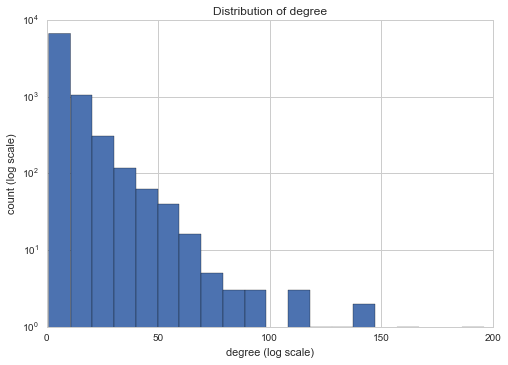

In [84]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

degreeDist = {}

with open("hw71_result.txt", "r") as f:
    for line in f:
        fields = line.strip().split('\t')
        key = fields[0].replace('"', '')
        value = fields[1]
        if key == "l":
            totalLinks = int(value)
        elif key == "n":
            totalNodes = int(value)
        else:
            # format: "d3"
            degree = int(key[1:])
            degreeDist[degree] = int(value)

print "Number of nodes =", totalNodes
print "Number of links =", totalLinks

degrees = [int(x) for x in degreeDist.keys()] 
counts = degreeDist.values()

fig, ax = plt.subplots()

ax.hist(degrees, weights = counts, bins = 20, log=True, align='mid')
plt.xlabel('degree (log scale)')
plt.ylabel('count (log scale)')
plt.title('Distribution of degree')
plt.show()

## HW 7.2: Shortest path graph distances (NLTK synonyms)
```
Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).
```

In [71]:
%%writefile Driver_Hw72.py
from numpy import random
from MrSssp_hw70 import MrSssp_hw70
from MrCheckTermination import MrCheckTermination
import json
import sys
import boto3
import botocore
import shutil
import time

import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--initFile", type=str)
parser.add_argument("--srcNode", type=str, help="The source node", default=None)
parser.add_argument("--destNode", type=str, help="The destination node", default=None)
parser.add_argument("--interSsspFolder", type=str, default=None)
parser.add_argument("--ec2-instance-type", type=str, default=None)
parser.add_argument("--num-ec2-instances", type=str, default=None)
parser.add_argument("-r", "--run", type=str)
args = parser.parse_args()

jobArgsBase = ['-r', args.run,
             '--no-strict-protocols']

if args.run == "emr":
    jobArgsBase += ["--pool-emr-job-flows"]
    
    if args.ec2_instance_type is not None:
        jobArgsBase += ["--ec2-instance-type", args.ec2_instance_type]
        
    if args.num_ec2_instances is not None:
        jobArgsBase += ["--num-ec2-instances", args.num_ec2_instances]

    
i = 1
startTime = time.time()
finished = False
interSsspFile = args.initFile # Use the initialized sssp in the first iteration
srcNodeInit = False

while(not finished):
    print "iteration %d: (%d sec since started)" % (i, time.time() - startTime)
    
    jobArgs = [interSsspFile] + jobArgsBase
    
    # Switch to use a different SSSP file name for subsequent iterations
    if args.run == "inline" or args.run == "local":
        interSsspFile = "_interSssp.txt"
    else:
        interSsspFile = args.interSsspFolder + "iter" + str(i) + "/"
        jobArgs += ["--no-output", "--output-dir", interSsspFile]
     
    # Have to initialize the source node during the first iteration
    job1_args = jobArgs
    if not srcNodeInit:
        job1_args += ["--initSrcNode", args.srcNode]
        srcNodeInit = True
    
    mr_job1 = MrSssp_hw70(args=job1_args)
    
    with mr_job1.make_runner() as runner: 
        runner.run()

        if args.run == "inline" or args.run == "local":
            # Generate the new SSSP based on job's output
            with open(interSsspFile, 'w') as f:            
                for line in runner.stream_output():
                    key, value =  mr_job1.parse_output_line(line)
                    f.write("%s\t%s\n" % (key,json.dumps(value)))

    # Check if we have reached termination state
    jobArgs = [interSsspFile, '--destNode', args.destNode] + jobArgsBase
    mr_job2 = MrCheckTermination(args=jobArgs)
    
    with mr_job2.make_runner() as runner: 
        runner.run()

        for line in runner.stream_output():
            key, value =  mr_job2.parse_output_line(line)
            if key == 1:
                print
                print "Shortest path:", value[2], "; Cost:", value[3]
            else:
                assert key == 0
                print
                print "Not Found"
                
            finished = True
    i += 1
    
print
print "Total time: %d sec" % (time.time() - startTime)
        

Overwriting Driver_Hw72.py


#### Run it locally

In [49]:
!python MrInitSssp.py synNet.txt -q -r inline --no-strict-protocols \
> initSssp.txt

In [50]:
!python Driver_Hw72.py -r local --initFile initSssp.txt --srcNode 7827 --destNode 536

iteration 1: (0 sec since started)
No handlers could be found for logger "mrjob.sim"
iteration 2: (3 sec since started)
iteration 3: (5 sec since started)
iteration 4: (8 sec since started)

Shortest path: [7827, 1426, 1668, 536] ; Cost: 3

Total time: 11 sec


#### Run it on Hadoop with HDFS

##### Initialize input file

In [36]:
!hdfs dfs -rm -r hw72_init

!python MrInitSssp.py synNet.txt -q -r hadoop --no-strict-protocols \
--output-dir hdfs://127.0.0.1/user/patrickng/hw72_init \
--no-output \
--no-strict-protocols \

16/03/10 11:36:07 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw72_init


In [37]:
!hdfs dfs -ls hdfs://127.0.0.1/user/patrickng/hw72_init

16/03/10 11:36:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   1 patrickng supergroup          0 2016-03-10 11:36 hdfs://127.0.0.1/user/patrickng/hw72_init/_SUCCESS
-rw-r--r--   1 patrickng supergroup     969970 2016-03-10 11:36 hdfs://127.0.0.1/user/patrickng/hw72_init/part-00000


##### Run the MrJob on Hadoop

In [39]:
!hdfs dfs -rm -r hw72_inter

!python Driver_Hw72.py -r hadoop \
--initFile hdfs://127.0.0.1/user/patrickng/hw72_init \
--interSsspFolder hdfs://127.0.0.1/user/patrickng/hw72_inter/ \
--destNode 536 \
--srcNode 7827 \


16/03/10 11:37:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `hw72_inter': No such file or directory
iteration 1: (0 sec since started)
No handlers could be found for logger "mrjob.compat"
iteration 2: (73 sec since started)
iteration 3: (141 sec since started)
iteration 4: (213 sec since started)

Shortest path: [7827, 1426, 1668, 536]

Total time: 289 sec


#### Run it on EMR

##### Initialize input file

In [44]:
!aws s3 mb s3://patng323-w261-hw72
!aws s3 cp synNet.txt s3://patng323-w261-hw72/input/
!aws s3 ls s3://patng323-w261-hw72/input/

make_bucket: s3://patng323-w261-hw72/
upload: ./synNet.txt to s3://patng323-w261-hw72/input/synNet.txt
2016-03-10 11:08:52        111 directed_toy.txt
2016-03-10 11:45:50     705298 synNet.txt


In [51]:
!aws s3 rm --recursive s3://patng323-w261-hw72/init
!echo "Wait 5.0s sec for S3 eventual consistency"
!sleep 5

!python MrInitSssp.py \
s3://patng323-w261-hw72/input/synNet.txt \
-r emr \
--pool-emr-job-flows \
--num-ec2-instances=1 \
--ec2-instance-type=m1.large \
--no-strict-protocols \
--no-output \
--output-dir s3://patng323-w261-hw72/init/ \
    


delete: s3://patng323-w261-hw72/init/_SUCCESS
delete: s3://patng323-w261-hw72/init/part-00000  
Wait 5.0s sec for S3 eventual consistency
Got unexpected keyword arguments: ssh_tunnel
using configs in /Users/patrickng/.mrjob.conf
using existing scratch bucket mrjob-0c26425c25d7acc1
using s3://mrjob-0c26425c25d7acc1/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrInitSssp.patrickng.20160310.035925.358808
writing master bootstrap script to /var/folders/dm/nsw7wjf91f1c74hgl17ldw040000gn/T/MrInitSssp.patrickng.20160310.035925.358808/b.py
Copying non-input files into s3://mrjob-0c26425c25d7acc1/tmp/MrInitSssp.patrickng.20160310.035925.358808/files/
Attempting to find an available job flow...
hash_object() is deprecated and will be removed in v0.5
Adding our job to existing job flow j-358X2FTMOOO57
Job launched 32.0s ago, status RUNNING: Running step (MrInitSssp.patrickng.20160310.035925.358808: Step 1 of 1)
Job launched 64.1s ago, statu

In [52]:
!aws s3 ls s3://patng323-w261-hw72/init/

2016-03-10 12:02:25          0 _SUCCESS
2016-03-10 12:02:19     969970 part-00000


#### Run the driver

In [59]:
!aws s3 rm --recursive s3://patng323-w261-hw72/inter
!echo "Wait 5.0s sec for S3 eventual consistency"
!sleep 5
    
!python Driver_Hw72.py \
-r emr \
--initFile s3://patng323-w261-hw72/init/ \
--interSsspFolder s3://patng323-w261-hw72/inter/ \
--num-ec2-instances=1 \
--ec2-instance-type=m1.large \
--destNode 536 \
--srcNode 7827


delete: s3://patng323-w261-hw72/inter/iter1/part-00000
delete: s3://patng323-w261-hw72/inter/iter1/_SUCCESS
Wait 5.0s sec for S3 eventual consistency
iteration 1: (0 sec since started)
No handlers could be found for logger "mrjob.conf"
iteration 2: (395 sec since started)
iteration 3: (828 sec since started)
iteration 4: (1235 sec since started)

Shortest path: [7827, 1426, 1668, 536] ; Cost: 3

Total time: 1668 sec


## HW 7.3: Exploratory data analysis (Wikipedia)
```
Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.```


## HW 7.4: Shortest path graph distances (Wikipedia)
```
Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of your MapReduce join skills!!)

Once your code is running, find some other shortest paths and report your results.```

##### Initialize input file

In [63]:
!aws s3 mb s3://patng323-w261-hw74
!sleep 3
!aws s3 rm --recursive s3://patng323-w261-hw74/init
!echo "Wait 5.0s sec for S3 eventual consistency"
!sleep 5

!python MrInitSssp.py \
s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt \
-r emr \
--pool-emr-job-flows \
--num-ec2-instances=4 \
--ec2-instance-type=m1.large \
--no-strict-protocols \
--no-output \
--output-dir s3://patng323-w261-hw74/init/ \

make_bucket: s3://patng323-w261-hw74/
Wait 5.0s sec for S3 eventual consistency


In [65]:
!aws s3 ls s3://patng323-w261-hw74/init/

2016-03-10 13:45:28          0 _SUCCESS
2016-03-10 13:31:01  535737703 part-00000
2016-03-10 13:31:05  537456160 part-00001
2016-03-10 13:30:54  536055558 part-00002
2016-03-10 13:39:14  537140533 part-00003
2016-03-10 13:39:30  536470791 part-00004


#### Run the driver

In [72]:
!aws s3 rm --recursive s3://patng323-w261-hw74/inter
!echo "Wait 5.0s sec for S3 eventual consistency"
!sleep 5
    
!python Driver_Hw72.py \
-r emr \
--initFile s3://patng323-w261-hw74/init/ \
--interSsspFolder s3://patng323-w261-hw74/inter/ \
--num-ec2-instances 4 \
--ec2-instance-type m1.xlarge \
--destNode 13466359 \
--srcNode 6176135



Wait 5.0s sec for S3 eventual consistency
iteration 1: (0 sec since started)
No handlers could be found for logger "mrjob.conf"
iteration 2: (1117 sec since started)
iteration 3: (1920 sec since started)

Shortest path: [6176135, 11607791, 13466359] ; Cost: 3

Total time: 2747 sec
